# Solving 1D Linear advection-diffusion-reaction transport using PINN

$\epsilon \frac{\partial^2u}{\partial x^2} + (1+\epsilon)\frac{\partial u}{\partial x} + u = 0$

Boundary condition:

$u(0) = 0 ~\&~ u(1) = 1$

We will solve this equation for two values of $\epsilon$: 
1. $\epsilon=0.05$ and

2. $\epsilon=5\times10^{-4}$

The exact solution for this differential equation is given by:

$u(x) = \frac{e^{-x}-e^{-\frac{x}{\epsilon}}}{e^{-1}-e^{-\frac{1}{\epsilon}}}$

### Importing the required libraries

In [ ]:
import time
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torch.optim as optim
from matplotlib import cm
import matplotlib.pyplot as plt
from pyDOE import lhs
from typing import List, Callable, Union

# Setting up the device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Neural network architecture for PINN

In [2]:
class PINN_Net(nn.Module):
    def __init__(self, hidden_sizes: List[int], ub: List[Union[int, float]], lb: List[Union[int, float]], activation: Callable):
        super(PINN_Net, self).__init__()
        
        
        self.input_size = 1
        self.output_size = 1
       

        self.hidden_sizes = hidden_sizes
        self.act = activation
        self.ub = torch.tensor(ub, dtype=torch.float32).to(DEVICE)
        self.lb = torch.tensor(lb, dtype=torch.float32).to(DEVICE)

        # Input layer
        self.fc1 = nn.Linear(self.input_size, self.hidden_sizes[0])
        nn.init.xavier_uniform_(self.fc1.weight)
        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for k in range(len(hidden_sizes)-1):
            layer = nn.Linear(hidden_sizes[k], hidden_sizes[k+1])
            nn.init.xavier_uniform_(layer.weight)
            self.hidden_layers.append(layer)
        # Output layer
        self.fc2 = nn.Linear(self.hidden_sizes[-1], self.output_size)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input layer
        x = (x - self.lb) / (self.ub - self.lb)    
        out = x
        out = self.act(self.fc1(out))
        # Hidden layers
        for layer in self.hidden_layers:
            out = self.act(layer(out))
        # Output layer
        out = self.fc2(out)
        return out


In [ ]:
class PINNManager():
    def __init__(self, net, lr, lb, ub, eps, Nc=30, log_name="loss_log"):
        """
        net: Neural network
        lr: Learning rate
        lb: left boundary
        ub: right boundary
        eps: Value of epsilon
        Nc: Number of collocation points
        """
        super(PINNManager, self).__init__()

        self.net = net  # model.py
        self.lr= lr if lr is not None else 0.003 # learning rate
        self.lb = torch.tensor(lb, dtype=torch.float32).to(DEVICE)
        self.ub = torch.tensor(ub, dtype=torch.float32).to(DEVICE) 
        self.eps = eps
        self.Nc = Nc
        self.loss_history = []  # [(epoch, overall_loss)]
        self.epoch_counter = 1000  # unified counter across Adam and L-BFGS
        self.loss_log_file = open(f"{log_name}.txt", "w")
        self.loss_log_file.write("Phase\tIteration\tOverallLoss\tBCLoss\tPDELoss\n")


        #############
        #self.optim = optim.Adam(self.pinn.parameters(),lr=self.lr)  # optimizer
        # LBFGS optimizer
        self.opt_LBFGS = optim.LBFGS(
            self.net.parameters(), 
            lr=1., 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       
        )
        self.iter = 0
        # Adam Optimizer
        self.opt_Adam = optim.Adam(self.net.parameters(), lr=self.lr)
    

    def predict(self,x):  
        x = 2*(x-self.lb)/(self.ub-self.lb) - 1
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32).to(DEVICE)
        x = x.view(-1, 1)  
        out = self.net.forward(x)
        u = out #out[:, 0:1]
        return u
    
    def all_predictions(self, x):
        
        x = torch.tensor(x, requires_grad=True).float().to(DEVICE).view(-1,1)
    
        self.net.eval()
       
        u, u_x, u_xx,_ = self.pde_loss(x)
        
        return u.detach().cpu().numpy(), u_x.detach().cpu().numpy(), u_xx.detach().cpu().numpy()
    
    def prepare_data(self):     

        ub = self.ub.detach().cpu().numpy() 
        lb = self.lb.detach().cpu().numpy() 

        def getData():
       
            left_x = lb.reshape((1,1)) 
            right_x = ub.reshape((1,1)) 


            # Collocation points
            x_col = lb + (ub - lb) * lhs(1, self.Nc)   # Generating collocation (LHS), this will be our collocation points where residual will be calculated

            # concatenate all xy for collocation
            x_col = np.concatenate((x_col, left_x, right_x), axis=0)  # Collocation points + Boundary points

            # convert to tensor
            x_left = torch.tensor(left_x, dtype=torch.float32).to(DEVICE)
            x_right = torch.tensor(right_x, dtype=torch.float32).to(DEVICE)
            x_col = torch.tensor(x_col, dtype=torch.float32).to(DEVICE)
            return x_col, x_left, x_right 

        return getData()  
    
    def pde_loss(self, x):  

        x = x.clone().detach().requires_grad_()
        #x.requires_grad = True
        u = self.predict(x)

        u_x = torch.autograd.grad(u, x, torch.ones_like(u),
                                    retain_graph=True,
                                    create_graph=True)[0]
        
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x),
                                    retain_graph=True,
                                    create_graph=True)[0]

        # Residual
        f0 = self.eps * u_xx + (1+self.eps) * u_x + u
        
        mse_f0 = torch.mean(torch.square(f0))
        mse_pde = mse_f0 

        return (u, u_x, u_xx, mse_pde)

    def bc_loss_left(self, x_bd):  
        
        if isinstance(x_bd, np.ndarray):
            x_bd = torch.tensor(x_bd, dtype=torch.float32).to(DEVICE)

        x_bd.requires_grad = True

        u = self.predict(x_bd)
        
        mse_bc_left = torch.mean(torch.square(u))
        return mse_bc_left

    def bc_loss_right(self, x):  
        x.requires_grad = True       
        u = self.predict(x) 
        mse_bc_right = torch.mean(torch.square(u-1)) 
        return mse_bc_right
    
    def _train_step(self, x_l, x_r, x_c):
        Xl = torch.tensor(x_l, requires_grad=True).float().to(DEVICE)
        Xr = torch.tensor(x_r, requires_grad=True).float().to(DEVICE)
        Xf = torch.tensor(x_c, requires_grad=True).float().to(DEVICE)
        
        _,_,_,mse_pde = self.pde_loss(Xf)
        mse_bc_left = self.bc_loss_left(Xl)
        mse_bc_right = self.bc_loss_right(Xr)
        bc_loss = mse_bc_left+mse_bc_right
        overall_loss = bc_loss + mse_pde
        return (overall_loss, bc_loss, mse_pde) 
    
    def _closure(self,x_l,x_r,x_c):
        overall_loss, bc_loss, pde_loss = self._train_step(x_l,x_r,x_c)
        self.opt_LBFGS.zero_grad()
        overall_loss.backward()
        self.epoch_counter += 1
        self.loss_history.append((self.epoch_counter, overall_loss.item()))
        
        self.iter += 1
        if self.iter % 1 == 0:
            print('epoch: {}  overall_loss: {:.3e} bc_loss: {:.3e} pde_loss: {:.3e}\n'.format(self.iter, overall_loss.item(), bc_loss.item(), pde_loss.item()))
            self.loss_log_file.write(f"LBFGS\t{self.iter}\t{overall_loss.item():.6e}\t{bc_loss.item():.6e}\t{pde_loss.item():.6e}\n")
        return overall_loss
    
    def train(self, epochs):
        x_c, x_l, x_r = self.prepare_data()
        self.net.train() # training mode
        for epoch in range(epochs):
            
            overall_loss, bc_loss, pde_loss = self._train_step(x_l,x_r,x_c) 
            
            self.opt_Adam.zero_grad()
            overall_loss.backward()
            self.opt_Adam.step()

            if (epoch+1) % 1 == 0:
                print('epoch: {}  overall_loss: {:.3e} bc_loss: {:.3e} pde_loss: {:.3e}\n'.format(epoch+1, overall_loss.item(), bc_loss.item(), pde_loss.item()))
                self.loss_log_file.write(f"Adam\t{epoch+1}\t{overall_loss.item():.6e}\t{bc_loss.item():.6e}\t{pde_loss.item():.6e}\n")
        self.opt_LBFGS.step(lambda: self._closure(x_l, x_r, x_c))
        self.loss_log_file.close()

    # Exact solution
    def exact(self, x):
        return (np.exp(-x)-np.exp(-x/self.eps))/(np.exp(-1)-np.exp(-1/self.eps))
    

    


        

## Solving the equation for $\epsilon=0.05$

In [4]:
# Create Instance of class PINNManager
lb = np.array([0.])
ub = np.array([1])  # infinity boundary
lr=0.001
net1 = PINN_Net([20,20],ub,lb,nn.Tanh()).to(DEVICE)
pinn1 = PINNManager(net1.to(DEVICE),lr,lb,ub,eps=0.05,Nc=30)  # Number of collocation points taken here is Nc=30

In [5]:
# Train the network and note down the time and 
tic = time.time()
pinn1.train(1000)
toc = time.time()
print(f"\nEnd of training of network, training time= {toc-tic}")

/tmp/ipykernel_8024/896784045.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xl = torch.tensor(x_l, requires_grad=True).float().to(DEVICE)
/tmp/ipykernel_8024/896784045.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xr = torch.tensor(x_r, requires_grad=True).float().to(DEVICE)
/tmp/ipykernel_8024/896784045.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xf = torch.tensor(x_c, requires_grad=True).float().to(DEVICE)
/home/prakash/anaconda3/envs/tensorflow/lib/python3.9/site-packages/torch/autograd/graph.py:825: UserWarni

epoch: 1  overall_loss: 1.848e+00 bc_loss: 2.023e-02 pde_loss: 1.828e+00

epoch: 2  overall_loss: 1.643e+00 bc_loss: 3.317e-02 pde_loss: 1.610e+00

epoch: 3  overall_loss: 1.460e+00 bc_loss: 5.359e-02 pde_loss: 1.407e+00

epoch: 4  overall_loss: 1.300e+00 bc_loss: 8.126e-02 pde_loss: 1.219e+00

epoch: 5  overall_loss: 1.162e+00 bc_loss: 1.157e-01 pde_loss: 1.046e+00

epoch: 6  overall_loss: 1.046e+00 bc_loss: 1.564e-01 pde_loss: 8.899e-01

epoch: 7  overall_loss: 9.516e-01 bc_loss: 2.022e-01 pde_loss: 7.494e-01

epoch: 8  overall_loss: 8.771e-01 bc_loss: 2.519e-01 pde_loss: 6.252e-01

epoch: 9  overall_loss: 8.211e-01 bc_loss: 3.042e-01 pde_loss: 5.169e-01

epoch: 10  overall_loss: 7.812e-01 bc_loss: 3.571e-01 pde_loss: 4.240e-01

epoch: 11  overall_loss: 7.549e-01 bc_loss: 4.090e-01 pde_loss: 3.458e-01

epoch: 12  overall_loss: 7.394e-01 bc_loss: 4.581e-01 pde_loss: 2.813e-01

epoch: 13  overall_loss: 7.317e-01 bc_loss: 5.027e-01 pde_loss: 2.290e-01

epoch: 14  overall_loss: 7.292e-01

### Exact vs Predicted

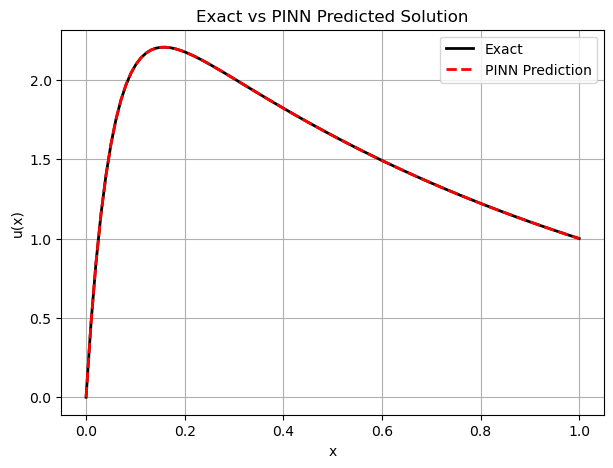

In [6]:
x = np.linspace(0,1,100)
u_exact = pinn1.exact(x)
u_pred, _, _ = pinn1.all_predictions(x)

plt.figure(figsize=(7,5))
plt.plot(x, u_exact, 'k-', label="Exact", linewidth=2)   # black solid line
plt.plot(x, u_pred, 'r--', label="PINN Prediction", linewidth=2)  # red dashed line

plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Exact vs PINN Predicted Solution")
plt.legend()
plt.grid(True)
plt.show()

### Error metrices:

    L1 error = np.mean(np.abs(diff))  # mean absolute error
    L2 eror = np.sqrt(np.mean(diff**2))  # root mean square error
    L_{\infty} error = np.max(np.abs(diff))  # Maximum absolute error

In [12]:
diff = u_exact - u_pred
err_L1 = np.mean(np.abs(diff))        # mean absolute error
err_L2 = np.sqrt(np.mean(diff**2))    # root mean square error
err_Linf = np.max(np.abs(diff))       # max error

# Save to a text file
with open("errors.txt", "w") as f:
    f.write(f"L1 error   : {err_L1:.6e}\n")
    f.write(f"L2 error   : {err_L2:.6e}\n")
    f.write(f"Linf error   : {err_Linf:.6e}\n")

print("Errors saved to errors.txt")

print(f'L1 error: {err_L1}\nL2 error: {err_L2}\nLinf error: {err_Linf}')

Errors saved to errors.txt
L1 error: 0.48337855107949146
L2 error: 0.6089158208075823
Linf error: 2.2053445844116313


### Save the predicted solution of PINN

In [7]:
np.savetxt('u_pred_0.05_pinn', u_pred)

## Solving the equation for $\epsilon = 5\times10^{-4}$

In [13]:
# Create Instance of class PINNManager
lb = np.array([0.])
ub = np.array([1])  # infinity boundary
lr=0.001
net2 = PINN_Net([20,20],ub,lb,nn.Tanh()).to(DEVICE)
pinn2 = PINNManager(net1.to(DEVICE),lr,lb,ub,eps=5e-4,Nc=30)  # Number of collocation points taken here is Nc=30

In [14]:
# Train the network and note down the time and 
tic = time.time()
pinn2.train(1000)
toc = time.time()
print(f"\nEnd of training of network, training time= {toc-tic}")

/tmp/ipykernel_8024/896784045.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xl = torch.tensor(x_l, requires_grad=True).float().to(DEVICE)
/tmp/ipykernel_8024/896784045.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xr = torch.tensor(x_r, requires_grad=True).float().to(DEVICE)
/tmp/ipykernel_8024/896784045.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xf = torch.tensor(x_c, requires_grad=True).float().to(DEVICE)


epoch: 1  overall_loss: 1.362e+02 bc_loss: 6.620e-11 pde_loss: 1.362e+02

epoch: 2  overall_loss: 1.268e+02 bc_loss: 8.029e-03 pde_loss: 1.268e+02

epoch: 3  overall_loss: 1.180e+02 bc_loss: 2.853e-02 pde_loss: 1.179e+02

epoch: 4  overall_loss: 1.097e+02 bc_loss: 5.986e-02 pde_loss: 1.096e+02

epoch: 5  overall_loss: 1.020e+02 bc_loss: 1.006e-01 pde_loss: 1.019e+02

epoch: 6  overall_loss: 9.473e+01 bc_loss: 1.492e-01 pde_loss: 9.458e+01

epoch: 7  overall_loss: 8.798e+01 bc_loss: 2.044e-01 pde_loss: 8.778e+01

epoch: 8  overall_loss: 8.169e+01 bc_loss: 2.648e-01 pde_loss: 8.143e+01

epoch: 9  overall_loss: 7.584e+01 bc_loss: 3.294e-01 pde_loss: 7.551e+01

epoch: 10  overall_loss: 7.040e+01 bc_loss: 3.970e-01 pde_loss: 7.000e+01

epoch: 11  overall_loss: 6.535e+01 bc_loss: 4.669e-01 pde_loss: 6.488e+01

epoch: 12  overall_loss: 6.067e+01 bc_loss: 5.382e-01 pde_loss: 6.013e+01

epoch: 13  overall_loss: 5.633e+01 bc_loss: 6.102e-01 pde_loss: 5.572e+01

epoch: 14  overall_loss: 5.231e+01

### Plot exact vs predicted

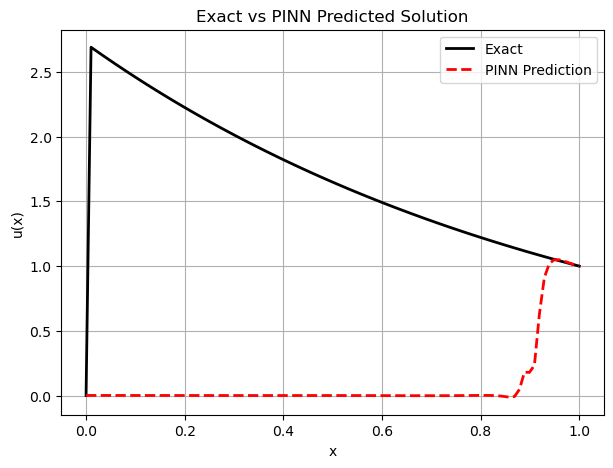

In [15]:
x = np.linspace(0,1,100)
u_exact = pinn2.exact(x)
u_pred, _, _ = pinn2.all_predictions(x)

plt.figure(figsize=(7,5))
plt.plot(x, u_exact, 'k-', label="Exact", linewidth=2)   # black solid line
plt.plot(x, u_pred, 'r--', label="PINN Prediction", linewidth=2)  # red dashed line

plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Exact vs PINN Predicted Solution")
plt.legend()
plt.grid(True)
plt.show()

### Error Metrices

In [16]:
diff = u_exact - u_pred
err_L1 = np.mean(np.abs(diff))        # mean absolute error
err_L2 = np.sqrt(np.mean(diff**2))    # root mean square error
err_Linf = np.max(np.abs(diff))       # max error

# Save to a text file
with open("errors.txt", "w") as f:
    f.write(f"L1 error   : {err_L1:.6e}\n")
    f.write(f"L2 error   : {err_L2:.6e}\n")
    f.write(f"Linf error   : {err_Linf:.6e}\n")

print("Errors saved to errors.txt")

print(f'L1 error: {err_L1}\nL2 error: {err_L2}\nLinf error: {err_Linf}')

Errors saved to errors.txt
L1 error: 1.600979061876782
L2 error: 1.7034109151093306
Linf error: 2.7039288403437123


### Save the predicted solution

In [17]:
np.savetxt('u_pred_5e-4_pinn', u_pred)